Simple Signorini problem with variable forces
=============================================
In this example we a solve a obstacle PDE. The special point in this example are the inequalyties in the corresponding differentialequation. On the unit square $\Omega = (0, 1) \times (0, 1)$, we consider the problem:
\begin{align*}
    -\Delta u &= f \text{ in } \Omega \\
    u &= 0 \text{ on } \Gamma_D \\
    \vec{n} \nabla u &= 0 \text{ on } \Gamma_N \\
    u -g &\geq 0 \text{ on } \Gamma_C \\
    -\vec{n} \nabla u &\leq 0 \text{ on } \Gamma_C \\
    \vec{n} \nabla u (u-g) &= 0 \text{ on } \Gamma_C
\end{align*}
Where $\Gamma_D = \{0\} \times [0, 1]$, $\Gamma_D = (0, 1) \times \{0, 1\}$ and $\Gamma_C = \{0\} \times [0, 1]$.
$g$ is the obstacle at the contact boundary $\Gamma_C$, this will be a simple parabola.  The condition $u -g \geq 0$ sets the contact, $-\vec{n} \nabla u \leq 0$ implies that the solution can extract a force on the obstacle not the other way around. The last complementary condition ensures, that we can only apply a force when there is a contact, otherwise the normal derivative has to be zero.

The other boundary conditions only exist to make the problem easier and to have a unique solution.

In the following we want to learn $u$ for different forces f.

In [1]:
import torchphysics as tp
import torch

We start like always. Define Spaces, Domains and Models:

In [2]:
X = tp.spaces.R2('x')
F = tp.spaces.R1('f')
U = tp.spaces.R1('u')

In [3]:
w, h = 10.0, 10.0
square = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
f_interval = tp.domains.Interval(F, 0.9, 2)

In [4]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(square*f_interval),
    tp.models.FCN(input_space=X*F, output_space=U, hidden=(50,50,50,50,50))
)

Next up the PDE, Dirichlet and Neumann conditions, here we use a filter function tp get the correct boundary parts.

In [5]:
inner_sampler = tp.samplers.RandomUniformSampler(square*f_interval, n_points=6500)


# here we divide the forces by a constant, to make them smaller. We could also have defined 
# a corresponding interval. But then we could get problems when we use the density for the samplers
# and have to be carefull that the density is big enough to sample points in the domain.
def pde_residual(u, x, f):
    return tp.utils.laplacian(u, x) - f/100.0

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition')

In [6]:
def filter_dirichlet(x):
    return torch.isclose(x[:, :1], torch.tensor(0.0))

dirichlet_sampler = tp.samplers.RandomUniformSampler(square.boundary*f_interval, density=50, 
                                                     filter_fn=filter_dirichlet)

def dirichlet_residual(u):
    return u

dirichlet_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=dirichlet_sampler,
                                                  residual_fn=dirichlet_residual,
                                                  name='dirichlet_condition')

In [7]:
def filter_neumann(x):
    return torch.logical_or(torch.isclose(x[:, 1:], torch.tensor(0.0)),
                            torch.isclose(x[:, 1:], torch.tensor(h)))

neumann_sampler = tp.samplers.RandomUniformSampler(square.boundary*f_interval, density=70,
                                                   filter_fn=filter_neumann)

def neumann_residual(u, x):
    normals = square.boundary.normal(x)
    return tp.utils.normal_derivative(u, normals, x)

neumann_condition = tp.conditions.PINNCondition(module=model, sampler=neumann_sampler, 
                                                residual_fn=neumann_residual)

Intresseting are the obstacle conditions. Here we have to use a inequaltiy for the trainig. For this
we use ``torch.clamp`` to set the residual to zero if the desiered condition is fulfilled.

In [8]:
def filter_obstacle(x):
    return torch.isclose(x[:, :1], torch.tensor(w))

obstacle_sampler = tp.samplers.RandomUniformSampler(square.boundary*f_interval, density=500, 
                                                    filter_fn=filter_obstacle)

def obstacle_residual(u, g):
    return torch.clamp(u-g, max=0)

def obstacle_fn(x):
    return -0.1 - ((x[:, 1:] - h/2.0) / 5.0)**2

obstacle_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=obstacle_sampler,
                                                  residual_fn=obstacle_residual,
                                                  name='obstacle_condition', 
                                                  data_functions={'g': obstacle_fn}, 
                                                  weight=10.0)

In [9]:
def sign_residual(u, x):
    grad = tp.utils.grad(u, x)
    return torch.clamp(grad[:, :1], max=0)

sign_condition = tp.conditions.PINNCondition(module=model, sampler=obstacle_sampler, 
                                             residual_fn=sign_residual)

In [10]:
def complementary_residual(u, g, x):
    grad = tp.utils.grad(u, x)
    return grad[:, :1]*(u-g)

complementary_condition = tp.conditions.PINNCondition(module=model,
                                                      sampler=obstacle_sampler,
                                                      residual_fn=complementary_residual,
                                                      data_functions={'g': obstacle_fn}, 
                                                      weight=10)

Start training:

In [11]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)
solver = tp.solver.Solver([pde_condition, dirichlet_condition, obstacle_condition,
                           neumann_condition, complementary_condition, sign_condition],
                          optimizer_setting=optim)

import pytorch_lightning as pl

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

trainer = pl.Trainer(gpus=1, # or None for CPU
                     max_steps=1500,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.5 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [12]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

# make sampler static:
pde_condition.sampler = pde_condition.sampler.make_static()
dirichlet_condition.sampler = dirichlet_condition.sampler.make_static()
obstacle_condition.sampler = obstacle_condition.sampler.make_static()
neumann_condition.sampler = neumann_condition.sampler.make_static()
complementary_condition.sampler = obstacle_condition.sampler
sign_condition.sampler = obstacle_condition.sampler

solver = tp.solver.Solver([pde_condition, dirichlet_condition, obstacle_condition,
                           neumann_condition, complementary_condition, sign_condition],
                          optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=2000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.5 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Now we learned the solution for different forces and can plot the solution

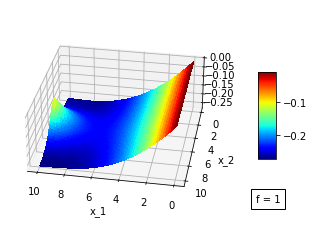

In [23]:
plot_sampler = tp.samplers.PlotSampler(square, n_points=2500, data_for_other_variables={'f':1})

fig = tp.utils.plot(model, lambda u: u[:, 0], plot_sampler, angle=[30, 100])
fig.axes[0].set_box_aspect(aspect = (2.5,2.5,1.5))